##  Test Comparison with Different Models – Here, we trial the YOLO baseline v11s.

#  Setup and depedependency

This project demonstrates the process of finel fine-tuning the YOLOv11 object detection model on a FDM printer dataset using the Ultralytics library and Roboflow for data management. The project involves setting up the Colab environment, installing necessary libraries, preparing the dataset, training the model, and evaluating its performance.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Jan 11 15:38:19 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
# Import the 'os' module to interact with the operating system
import os

# Get the current working directory and assign it to the variable 'HOME'
HOME = os.getcwd()

# Print the current working directory to verify where the code is being executed from
print(HOME)

/content


## Install YOLO11 via Ultralytics

This command installs the necessary libraries—Ultralytics (for YOLO models), Supervision, and Roboflow—in Google Colab. The `ultralytics.checks()` function verifies the installation and dependencies to ensure everything is set up correctly. ( If successful, it will show to: Setup Complete)

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [ ]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 5.35M/5.35M [00:00<00:00, 95.9MB/s]
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 104k/104k [00:00<00:00, 55.3MB/s]
image 1/1 /content/dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 84.5ms
Speed: 11.1ms preprocess, 84.5ms inference, 1126.9ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpeg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 56.1ms
Speed: 3.3ms preprocess, 56.1ms inference, 554.8ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

tensor([[3.0705e+02, 6.4341e+02, 5.2919e+02, 1.2558e+03],
        [6.1400e+01, 2.4994e+02, 6.5165e+02, 9.7412e+02],
        [1.7803e+00, 3.5551e+02, 6.3404e+02, 1.2788e+03],
        [1.1933e+00, 3.5620e+02, 3.8455e+02, 1.2776e+03],
        [6.2615e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.6832, 0.6284, 0.5941, 0.3923, 0.3875], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

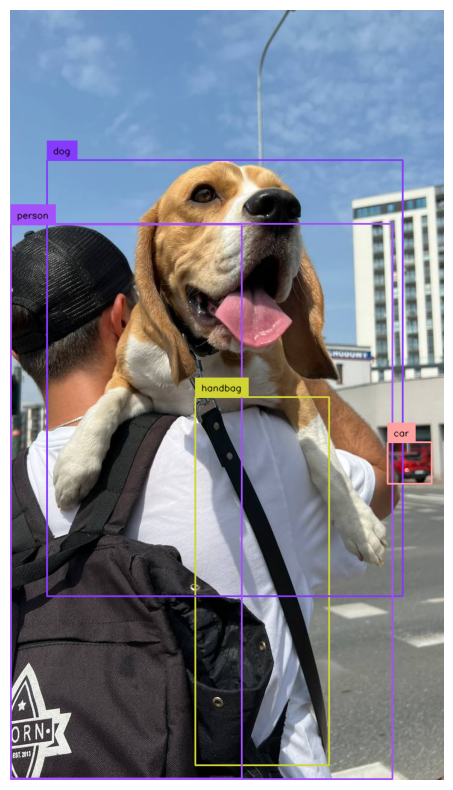

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Setup of Our FDM Anomalies Anotation Dataset.  

Here, we use the Roboflow API to fetch data directly from my private dataset. Please do not share this key.

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. Here is the data structured.  In data.yaml also cross check with class which look like :

train: ../train/images

val: ../valid/images

test: ../test/images

nc: 4
names: ['DEFECT- Cracks', 'DEFECT- Layer-shift', 'DEFECT- Spaghetti', 'DEFECT- Stringging']

datasets/  
│── train/  
│   ├── images/  
│   ├── labels/  
│── valid/  
│   ├── images/  
│   ├── labels/  
│── test/  
│   ├── images/  
│   ├── labels/  
│── data.yaml  


In [ ]:
# Create a directory named 'datasets' in the home directory to store dataset files
!mkdir {HOME}/datasets

# Change the current working directory to the newly created 'datasets' folder
%cd {HOME}/datasets

# Import the 'userdata' module from Google Colab (though not used here)
from google.colab import userdata

# Import the Roboflow library, which is used for dataset management, model training, and deployment
from roboflow import Roboflow

# Install the Roboflow package, which provides functionality for interacting with the Roboflow API
!pip install roboflow


from roboflow import Roboflow
rf = Roboflow(api_key="8J372F5TEuPXTyuBcvKm")
project = rf.workspace("comparison-small-dataset").project("small-dataset-7eoxe")
version = project.version(2)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Small-dataset--2 in yolov11:: 100%|██████████| 5638/5638 [00:01<00:00, 5186.33it/s]


## To Start Training On Our Dataset. This setup is defult as we check the baseline model of yolo.

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=25 batch=16 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 132MB/s] 
New https://pypi.org/project/ultralytics/8.3.59 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Small-dataset--2/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cl

NOTE: The training output above displays the valuable data for each epoch, including the final timing, class-wise mAP50, and speed. A CSV file containing this data will be saved in the `/runs/detect/train/results.csv` file within the content folder.

#The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them. It will come as beolw example in Output.


In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    R_curve.png		 val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		 val_batch0_pred.jpg
confusion_matrix.png				    results.png		 val_batch1_labels.jpg
events.out.tfevents.1736610097.d07734b71faf.1624.0  train_batch0.jpg	 val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg	 val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2280.jpg  val_batch2_pred.jpg
labels.jpg					    train_batch2281.jpg  weights
P_curve.png					    train_batch2282.jpg
PR_curve.png					    train_batch2.jpg


NOTE: The outputs, including results like the confusion matrix and various charts, are saved in the location `/runs/detect/train`. Here below cells, we will check an example of the confusion matrix and one prediction result with confidance score, or alternatively, you can go directly to the folder to view or download it.

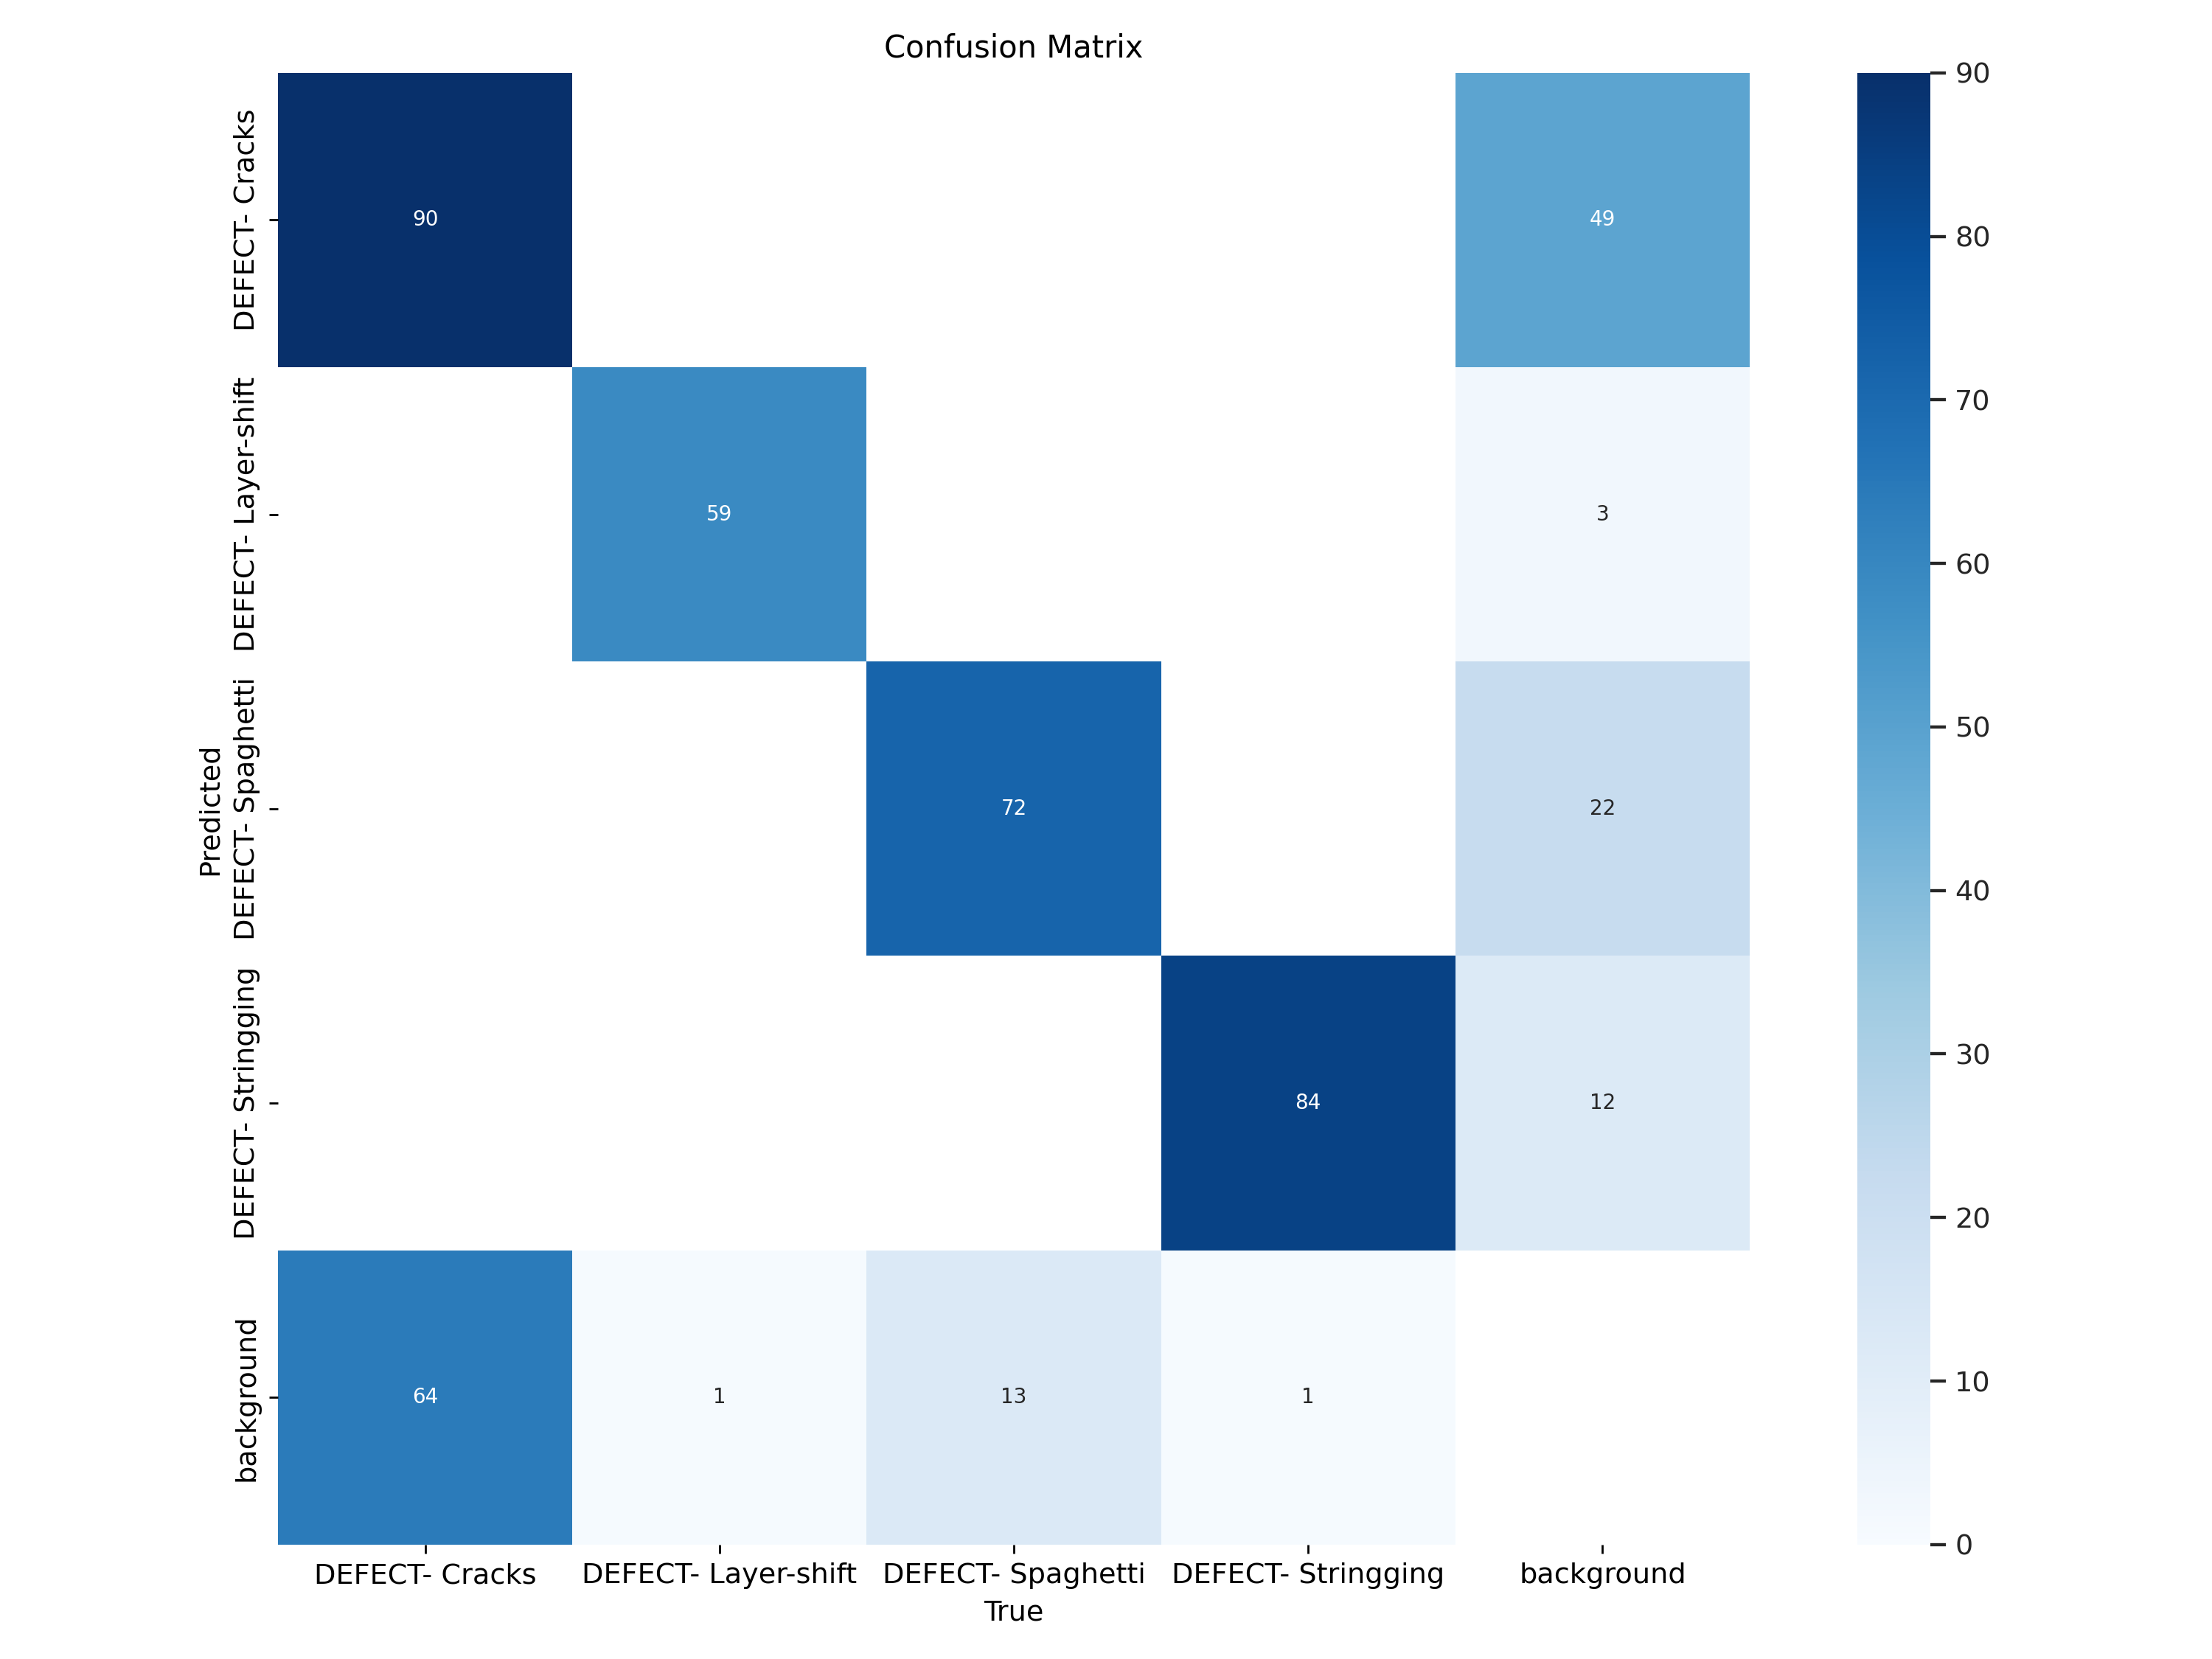

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

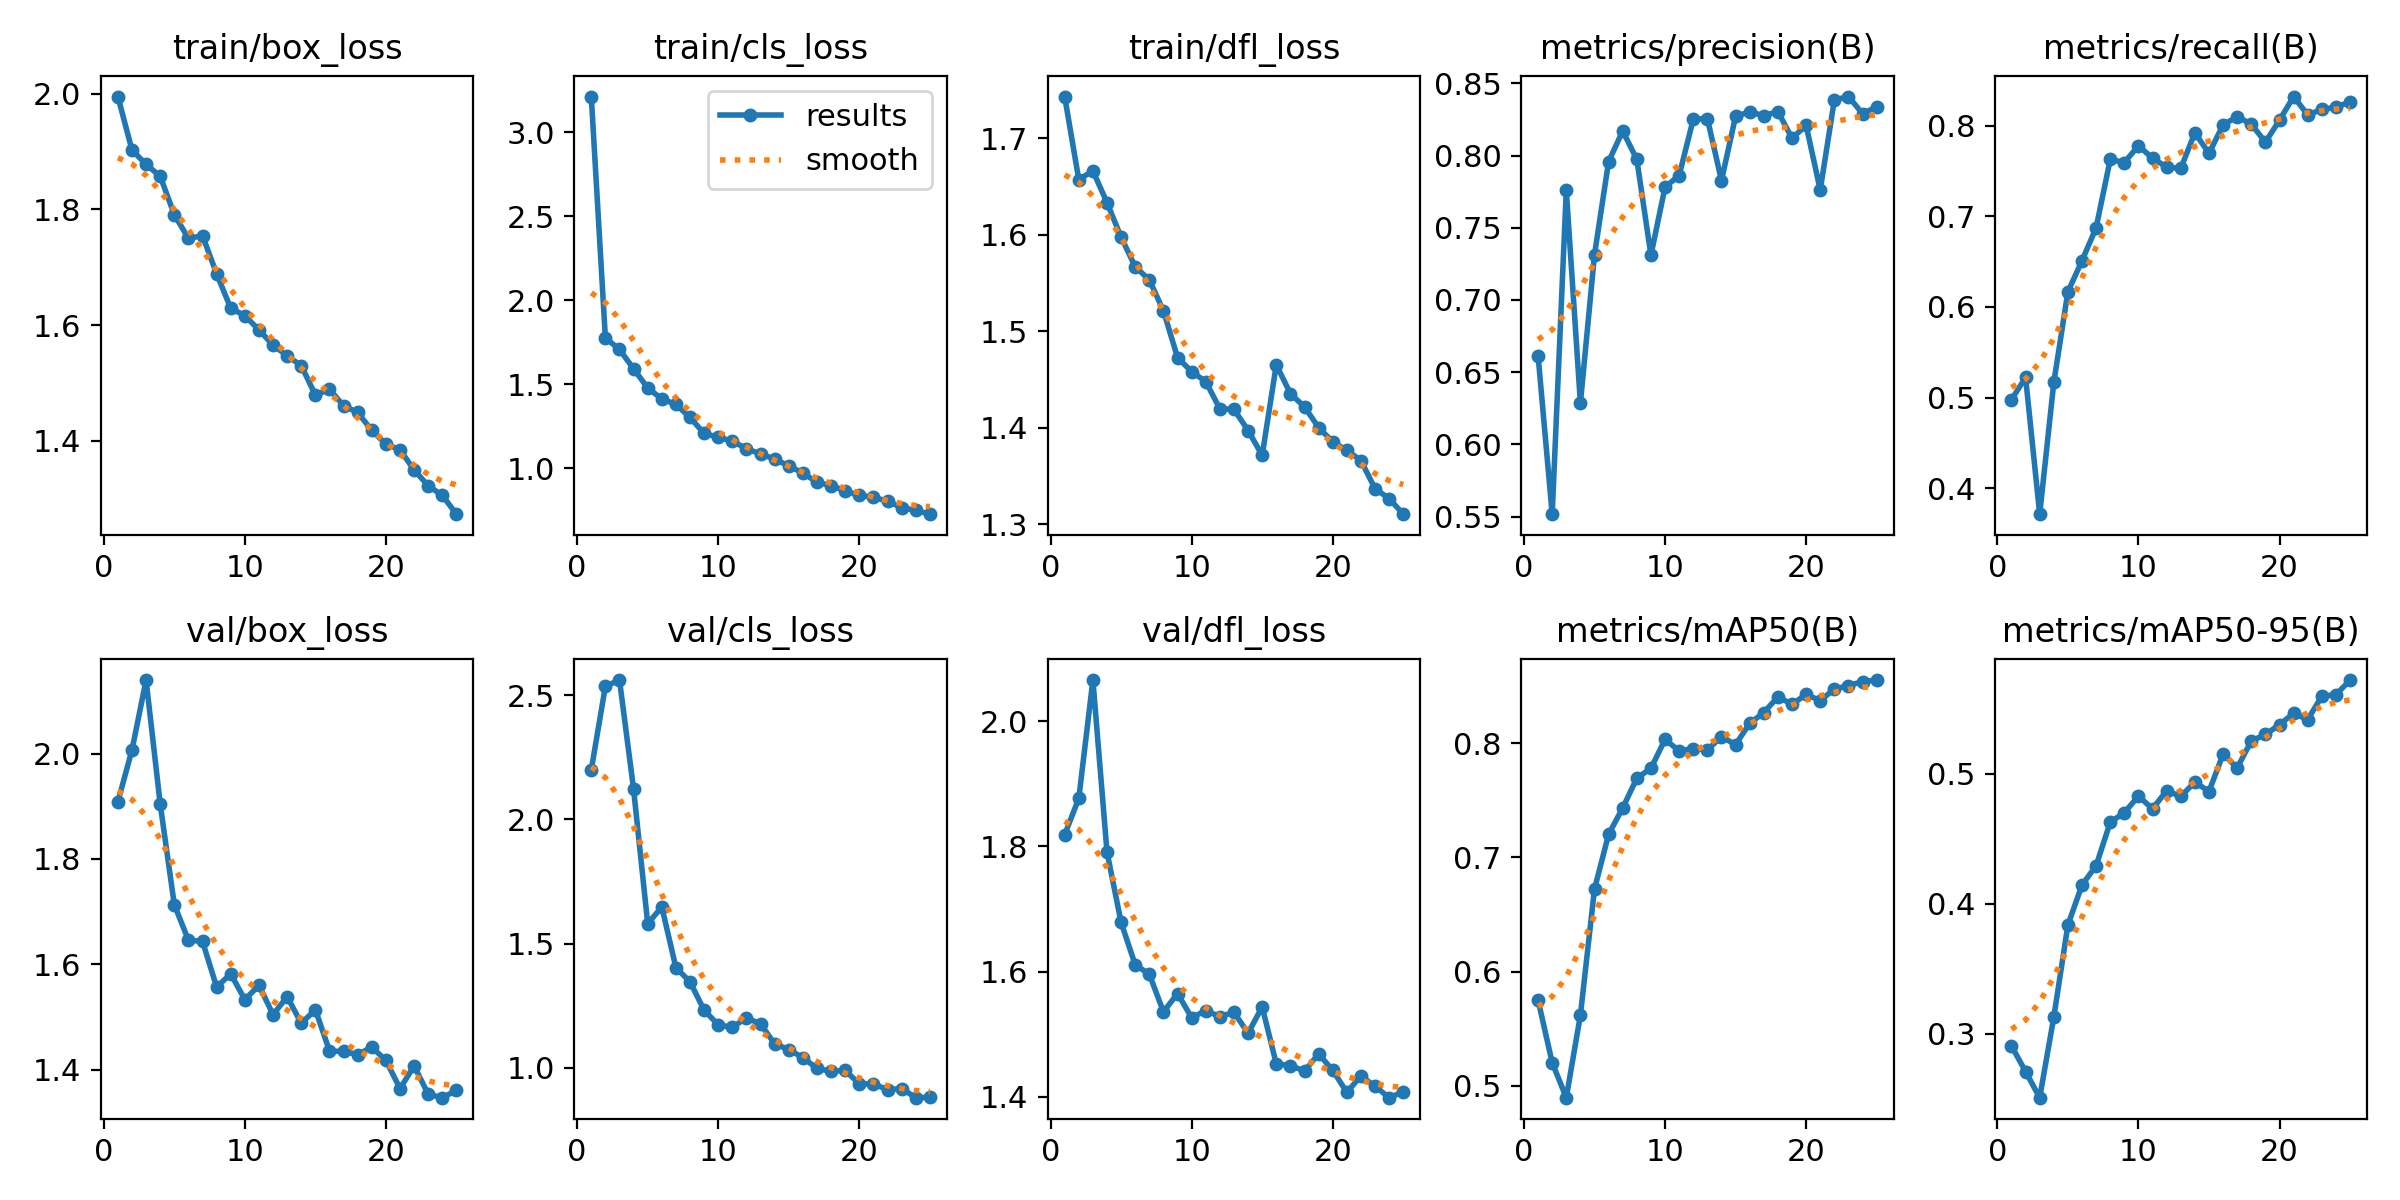

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

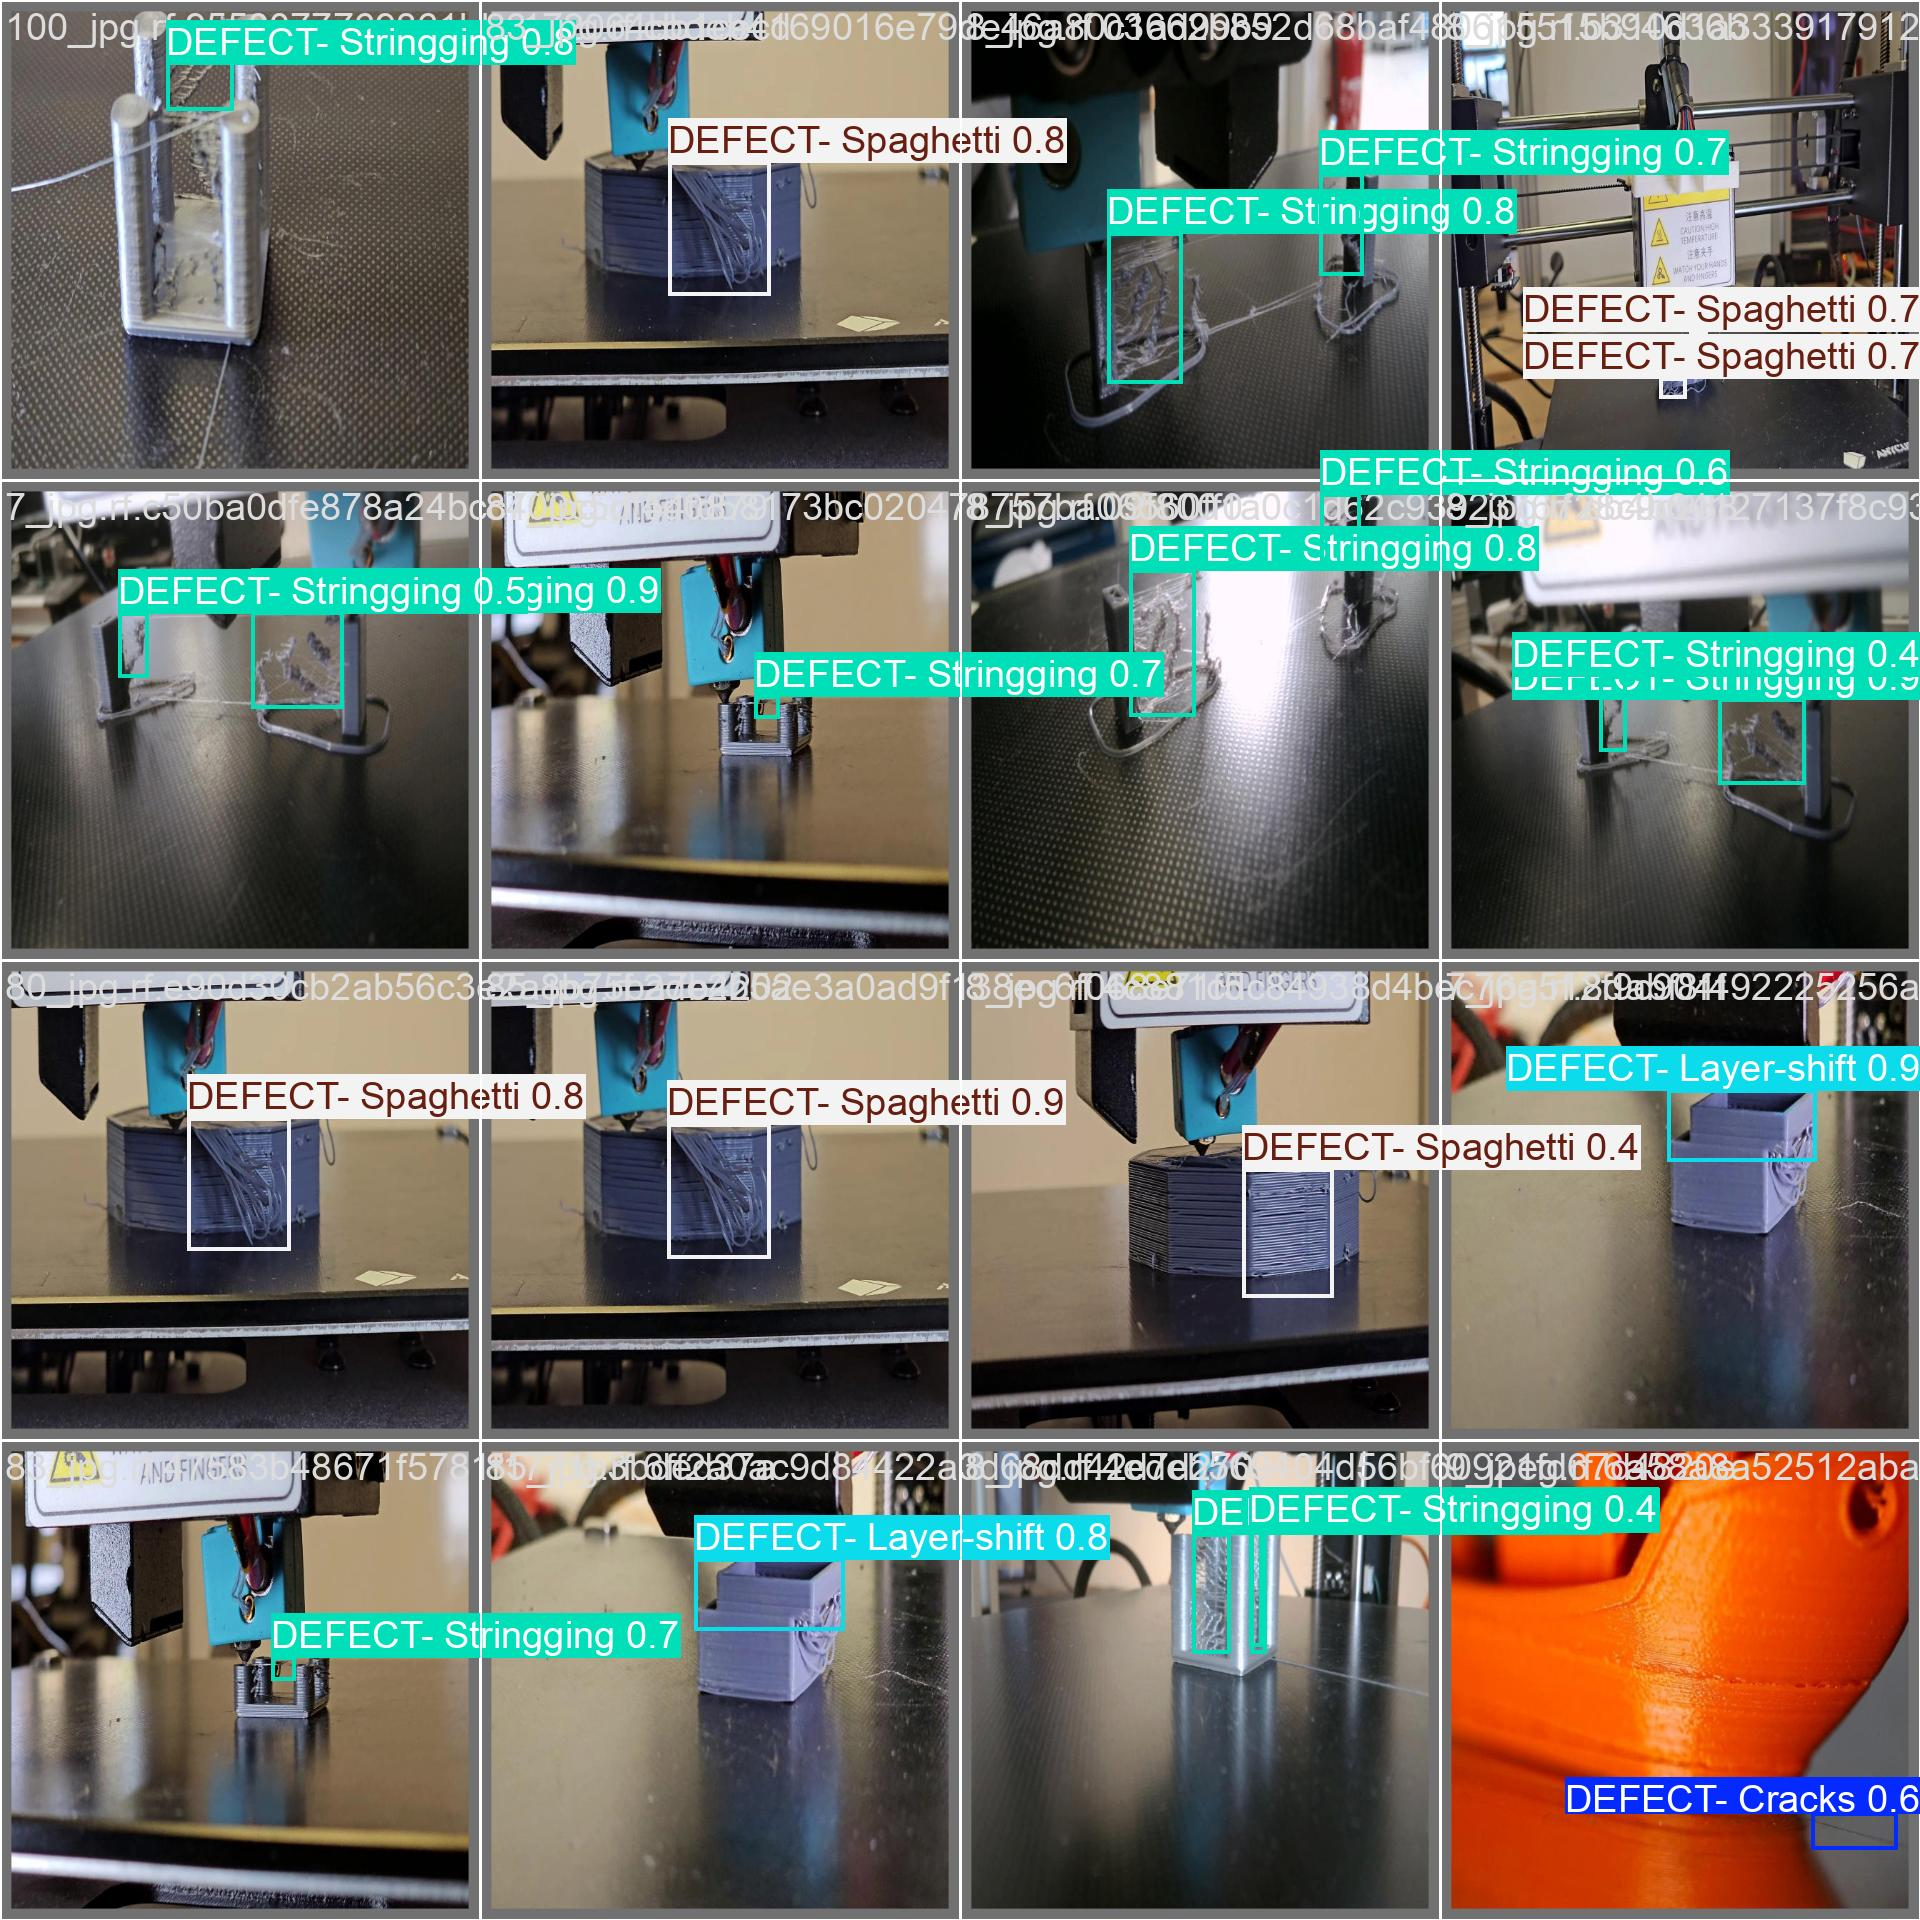

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

The command runs YOLO in *validation* mode (`mode=val`) for object detection (`task=detect`), using the best model weights (`best.pt`) from a previous training session. It validates the model on a dataset specified by the `data.yaml` file.



In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Small-dataset--2/valid/labels.cache... 256 images, 0 backgrounds, 0 corrupt: 100% 256/256 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 174, len(boxes) = 384. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 16/16 [00:04<00:00,  3.33it/s]
                   all        256        384      0.836      0.826      0.855      0.573
        DEFECT- Cracks         77        154      0.693      0.498      0.565       0.31
   DEFECT- Layer-shift         60         60      0.965      0.983      0.993      0.713
     DEFECT- Spaghetti        

NOTE: The above output shows the performance of the YOLOv11s model after validation on our FDM printing unseen data. It achieved a high mean Average Precision (mAP) of 0.855 as Basline test, with the best results for "DEFECT- Layer-shift" (0.993). The model processed images with an average speed of 9.5ms per image.

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

#Once training is complete, the output will follow this hierarchical structure, and you can find the trained weight file at:  

**run > detect > train > weights > best.pt**  

Here, **best.pt** represents the best-performing model, while **last.pt** corresponds to the model from the final epoch.

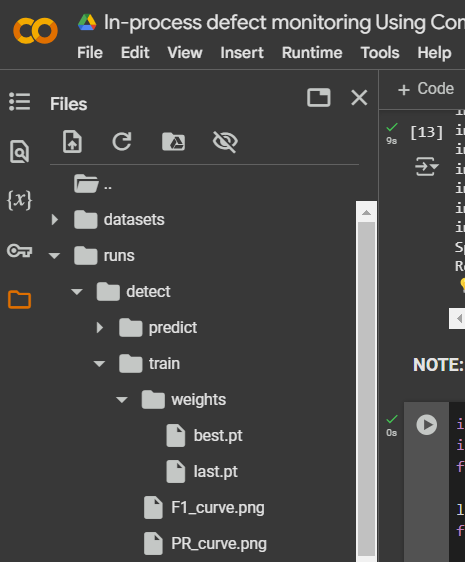